# Filter based on a subset of the points

This notebook shows an example of how to filer based on a subset of points.  

I'll take a random subsample of the filter points and use those points to generate a sequence of ellipses with decreasing volume.  Then I'll use those ellipses to filter the other data, which wasn't used to generate the ellipses. 

In [1]:
%matplotlib inline

# Future 
from __future__ import print_function

# Numpy imports 
import numpy as np
import numpy.random as random

import scipy as sp
import scipy.linalg as la


# Import matplotlib.pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# My imports 
from ellipsoidal_outlier_detector import (
    EllipsoidSolver, get_outliers, get_total_partition, get_filter_index)



EPS = sp.finfo(float).eps

# Generate example points

I will generate Lots of points and then pick random sample of 10% or so of those points. 

In [2]:
# Generate random samples for testing the algorithm 
Mtotal = 80000      # Total number of samples
M = 1000            # Number to use in fitting ellipses

# Dimensions of the filter space and 
d = 8



# Dimensions of the ellipsoid space
Na = int(d * (d+1) / 2.0 + d)


## Pick the elements to use in the fitting 
I_choice = random.choice(Mtotal, M, replace=False)
bool_Ifit = sp.zeros((Mtotal,), dtype=bool)
bool_Ifit[I_choice] = True



## Define a sample of variables
mean = np.array(d * [5.0,])
cov = sp.eye(d) + 5.0

## Generate a random sample
xarray = random.multivariate_normal(mean, cov, Mtotal)

### Add outliers as some percentage of points
percent_outliers = 0.02    # 2% of points are outliers
Noutliers = int(sp.floor(Mtotal * percent_outliers))
xarray[:Noutliers, :] = random.laplace(5, scale =10.0001, size=(Noutliers, d))

# Separate the data into the random sample used to fit ellipses
xarray_fit = xarray[bool_Ifit, :]


## Problem size estimates
print("Print some rough problem size estimates:")
print("d = {0}\nM = {1}\nNa= {2}".format(d, M, Na), end='\n\n')
print("d**2 = {0}".format(d**2))
print("Na**2 = {0}".format(Na**2), end=2*'\n')

print("Number of indexes choosen: {0}".format(I_choice.size))
print('xarray.shape     = {0}'.format(xarray.shape))
print('xarray_fit.shape = {0}'.format(xarray_fit.shape))

Print some rough problem size estimates:
d = 8
M = 1000
Na= 44

d**2 = 64
Na**2 = 1936

Number of indexes choosen: 1000
xarray.shape     = (80000, 8)
xarray_fit.shape = (1000, 8)


# Get the total partition using random subsample: `xarray_fit`

This interface applies the get_outliers function until the number of samples in xarray is reduced by the factor alpha. The output the same as get_outliers but now there are sequences of the output parameters for each outlier detection step.

In [3]:
## Do a partition until the number of points is reduced to half
bool_Iin_list, bool_Iout_list, vols, As, bs = get_total_partition(xarray_fit, alpha=0.5)

## Fine the filtrations of the 
bool_Iin_total_list = [get_filter_index(xarray, _A, _b) for _A, _b in zip(As, bs)]

# How does the fraction of points decrease?

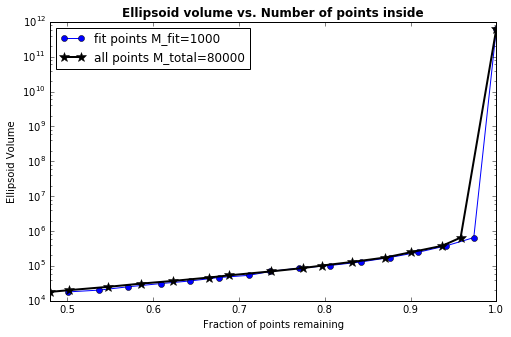

In [4]:

# Compute the number of points left for the fitting and total case
Ms = sp.array([bool_Iin.sum() for bool_Iin in bool_Iin_list])
Ms_ratio = Ms / float(Ms.max())

Ms_total = sp.array([_bool_Iin_total.sum() for _bool_Iin_total in bool_Iin_total_list])
Ms_total_ratio = Ms_total / float(Ms_total.max())




## Plot
fig = plt.figure(0, (8,5))
ax = fig.add_subplot(1,1,1)



ax.semilogy(Ms_ratio, vols, linewidth=1, marker='o', c='b', 
            label='fit points M_fit={0}'.format(M))
ax.semilogy(Ms_total_ratio, vols, linewidth=2, marker='*', markersize=10, c='k', 
            label='all points M_total={0}'.format(Mtotal))

ax.set_title("Ellipsoid volume vs. Number of points inside", 
             fontweight='bold', fontsize='large')
ax.set_ylabel("Ellipsoid Volume")
ax.set_xlabel("Fraction of points remaining")
ax.set_xbound(Ms_total_ratio.min(), Ms_total_ratio.max())
ax.legend(loc='upper left')



# New function for getting the filter index from (A, b)

In [5]:
help(get_filter_index)

Help on function get_filter_index in module ellipsoidal_outlier_detector:

get_filter_index(xarray_new, A, b)
    Return an index array for selecting the point which are inside
    the ellipse defined by (A, b).
    
    in 
    --
    xarray_new    - (M', ndim)
    A             - (ndim, ndim)
    b             - (ndim,)
    
    out
    ---
    bool_In       - (M',) Index array for selecing points in the ellipse
    
    
    * usage *
    ---------
    xarray[bool_Iin, :]     --->    gives the points inside the ellipse

